In [2]:
# python
import os, sys, pickle
from itertools import combinations, combinations_with_replacement, product

# stats
import numpy as np
import pandas as pd

# plot
import seaborn as sns
import matplotlib.pyplot as plt

# neural networks
import torch, torch.utils.model_zoo  # required to load nets
from torchvision.models.feature_extraction import (
    get_graph_node_names,
    create_feature_extractor,
)

# thesis library
from lib.functions_base_analysis import *
from lib.functions_second_analysis import *
from lib.functions_scripting import *
from lib.ImageDataset import ImageDataset
from lib.NetworkScorer import NetworkScorer
from lib.PatternGenerator import Pattern_Generator
from lib.ActivationPattern import Activation_Pattern
from lib.transforms import VisualPriorRepresentation


PATH_IMAGES = "../images and ratings/imageversions_256"
PATH_RATINGS = "../images and ratings/ratings"

PATH_INTEGRATION = "../data csv/integration"
PATH_INTEGRATION_AVERAGE = "../data csv/integration average"
PATH_INTEGRATION_MAXPOOL = "../data csv/integration maxpool"

PATH_IBCORR = "../data csv/ibcorr"
PATH_IBCORR_AVERAGE = "../data csv/ibcorr average"
PATH_IBCORR_MAXPOOL = "../data csv/ibcorr maxpool"

PATH_RESULTS = "../results"
PATH_PLOTS = "../plots"


# uniform blocking across this script to avoid bugs
BLOCKING_GROUPS = np.insert(np.repeat(range(1, 16 + 1), 3), 0, 0)


_study = "short presentation"
_scale = "scale16"
_dataset = "places1"

# ibcorr analysis 

In [ ]:
for model_name in MODEL_NAMES:
    print(model_name)

    # Import taskonomy model...
    VisualPriorRepresentation._load_unloaded_nets([model_name])
    net = VisualPriorRepresentation.feature_task_to_net[model_name]

    # ...and create activation extractor from it
    _, eval_nodes = get_graph_node_names(net)
    return_nodes = {node: node for node in eval_nodes if "conv" in node or "fc" in node}
    activation_extractor = create_feature_extractor(net, return_nodes=return_nodes)

    for dataset_name in DATASET_NAMES:
        print(dataset_name)

        for scale_name in SCALE_NAMES:

            dataset = ImageDataset(os.path.join(PATH_IMAGES, dataset_name, scale_name))

            correlations, selfsimilarity, l2norm = calculate_dataset_metrics(
                dataset, activation_extractor
            )

            correlations.fillna(correlations.mean())
            selfsimilarity.fillna(selfsimilarity.mean())
            l2norm.fillna(l2norm.mean())

            correlations.to_csv(
                os.path.join(
                    PATH_INTEGRATION,
                    model_name,
                    dataset_name,
                    scale_name,
                    "correlations.csv",
                ),
                index=False,
                header=False,
            )
            selfsimilarity.to_csv(
                os.path.join(
                    PATH_INTEGRATION,
                    model_name,
                    dataset_name,
                    scale_name,
                    "selfsimilarity.csv",
                ),
                index=False,
                header=False,
            )
            l2norm.to_csv(
                os.path.join(
                    PATH_INTEGRATION, model_name, dataset_name, scale_name, "l2norm.csv"
                ),
                index=False,
                header=False,
            )

# load, average, maxpool, create folders

In [3]:
dfi = load_integration(PATH_INTEGRATION)
#dfi_a = load_integration(PATH_INTEGRATION_AVERAGE)

In [4]:
df_ibc = load_ibcorr(PATH_IBCORR)
#df_ibc_b = load_ibcorr(PATH_IBCORR_AVERAGE)

In [5]:
dfp = load_pvalues(PATH_IBCORR)

## average

In [ ]:
# integration
dfi_a = dfi.unstack("layer").groupby(BLOCKING_GROUPS, axis=1).mean()
#dfi_a.groupby("dataset").mean().T.plot() # control sign

In [ ]:
dfc_a = -dfi_a
for da, sc, mo in product(DATASET_NAMES, SCALE_NAMES, MODEL_NAMES):
    dfc_a.loc[(mo, da, sc)].to_csv(
        os.path.join(PATH_INTEGRATION_AVERAGE, mo, da, sc, "correlations.csv"),
        index=False,
        header=False,
    )

In [ ]:
# ibc
df_ibc_a = df_ibc.unstack("layer").groupby(BLOCKING_GROUPS, axis=1).mean().stack().to_frame()

In [ ]:
for st, sc, mo in product(STUDY_NAMES, SCALE_NAMES, MODEL_NAMES):
    df_ibc_a.loc[(mo, st, sc)].to_csv(
        os.path.join(PATH_IBCORR_AVERAGE, mo, da, sc, "ib_correlations.csv"),
        index=False,
        header=False,
    )

## maxpool

In [ ]:
# ibc
df_ibc_m = (
    df_ibc.unstack("layer")
    .groupby(BLOCKING_GROUPS, axis=1)
    .max()
    .stack()
    .to_frame()
    .rename({0: "ibcorr"}, axis=1)
)

In [ ]:
for st, sc, mo in product(STUDY_NAMES, SCALE_NAMES, MODEL_NAMES):
    df_ibc_m.loc[(mo, st, sc)].to_csv(
        os.path.join(PATH_IBCORR_MAXPOOL, mo, st, sc, "ib_correlations.csv"),
        index=False,
        header=False,
    )

In [ ]:
# integration
def maxpool_integration(__study):
    """df_ibc and dfi need to be fully stacked in the workspace (have only 1 column)"""

    bestlayers = (
        df_ibc.unstack("layer")
        .T.droplevel(None)
        .groupby(BLOCKING_GROUPS)
        .idxmax()
        .T.reorder_levels(["study", "scale", "model"])
        .sort_index()
    )

    bestlayers.columns.name = "layer"
    bestlayers = (
        bestlayers.stack("layer")
        .loc[__study]
        .reset_index()
        .set_index("layer")
        .values.tolist()
    )

    dfi_study = (
        dfi.reorder_levels(["dataset", "scale", "model", "img", "layer"])
        .loc[studyname2datasetname(__study)]
        .unstack("img")
        .loc[bestlayers, :]
    )

    new_layer_idx = dfi_study.groupby(["scale", "model"]).cumcount()

    dfi_study = (
        dfi_study.assign(blocklayer=new_layer_idx)
        .reset_index()
        .drop("layer", axis=1)
        .rename({"blocklayer": "layer"}, axis=1)
        .set_index(["scale", "model", "layer"])
        .unstack("layer")
        .stack("img")
    )

    return dfi_study


for st in STUDY_NAMES:
    # save as correlation, not integration
    dfc = -maxpool_integration(st)
    da = studyname2datasetname(st)

    for mo, sc in product(MODEL_NAMES, SCALE_NAMES):
        dfc.loc[(sc, mo)].to_csv(
            os.path.join(PATH_INTEGRATION_MAXPOOL, mo, da, sc, "correlations.csv"),
            index=False,
            header=False,
        )

In [ ]:
dfi_m = load_integration(PATH_INTEGRATION_MAXPOOL)

In [ ]:
#load_integration(PATH_INTEGRATION_MAXPOOL).unstack("layer").groupby(["scale"]).mean().T.plot()

## create folder structure

In [ ]:
# imageversions
for dataset_name in DATASET_NAMES:
    for scale_name in SCALE_NAMES:
        for version_name in ("full", "version1", "version2"):
            os.makedirs(
                os.path.join(PATH_IMAGES, dataset_name, scale_name, version_name)
            )

In [ ]:
# data csv
# integration
for model_name in MODEL_NAMES:
    for dataset_name in DATASET_NAMES:
        for scale_name in SCALE_NAMES:
            dir_path = os.path.join(
                PATH_INTEGRATION_MAXPOOL, model_name, dataset_name, scale_name
            )
            os.makedirs(dir_path)

In [ ]:
# ibcorr
for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:
            os.makedirs(
                os.path.join(PATH_IBCORR_MAXPOOL, model_name, study_name, scale_name)
            )

In [ ]:
# data mat
for model_name in MODEL_NAMES:
    os.makedirs(os.path.join("../data mat", "ibcorr", model_name))

In [ ]:
for model_name in MODEL_NAMES:
    os.makedirs(os.path.join("../data mat", "ibcorr blocked", model_name))

In [ ]:
for model_name in MODEL_NAMES:
    os.makedirs(os.path.join("../data mat", "ibcorr blocked_integr", model_name))

In [ ]:
for model_name in MODEL_NAMES:
    os.makedirs(os.path.join("../data mat", "integration", model_name))

In [ ]:
for model_name in MODEL_NAMES:
    os.makedirs(os.path.join("../data mat", "integration blocked", model_name))

# initial results & scale selection

In [ ]:
# # unblocked ibcorr
# df1 = (
#     df_ibc.loc[(slice(None), _study, slice(None)), :]
#     .droplevel(["study", "scale"])
#     .fillna(0)
# )

# # unblocked integration
# df2 = (
#     dfi.loc[(slice(None), _dataset, _scale), :]
#     .droplevel(["dataset", "scale"])
#     .fillna(0)
# )

# # unblocked pvalues
# df3 = (
#     dfp.loc[(slice(None), _study, slice(None)), :]
#     .droplevel(["study", "scale"])
#     .fillna(0)
# )

In [6]:
dfp = dfp.unstack("layer")
df_ibc = df_ibc.unstack("layer")
df_ibc.columns = df_ibc.columns.droplevel(None)

In [7]:
# plot only significant pixels, bonferroni MCC
adjusted_pvalue = 0.05 / 49
df_ibc_s = df_ibc.copy()
df_ibc_s.iloc[(dfp > adjusted_pvalue).values] = np.nan

In [19]:
# better visualizaiton, sort models by integration / integration-beauty correlation
# order = dfi.abs().groupby("model").sum().sum(axis=1).argsort()
order = df_ibc_s.abs().groupby("model").sum().sum(axis=1).argsort()

# model names to numbers mapping
modelnum_mapping = order.sort_values()
modelnum_mapping

model
edge_texture         0
fixated_pose         1
keypoints2d          2
segment_semantic     3
edge_occlusion       4
point_matching       5
jigsaw               6
inpainting           7
class_object         8
denoising            9
depth_euclidean     10
egomotion           11
curvature           12
reshading           13
class_scene         14
segment_unsup25d    15
autoencoding        16
nonfixated_pose     17
keypoints3d         18
room_layout         19
normal              20
segment_unsup2d     21
vanishing_point     22
dtype: int64

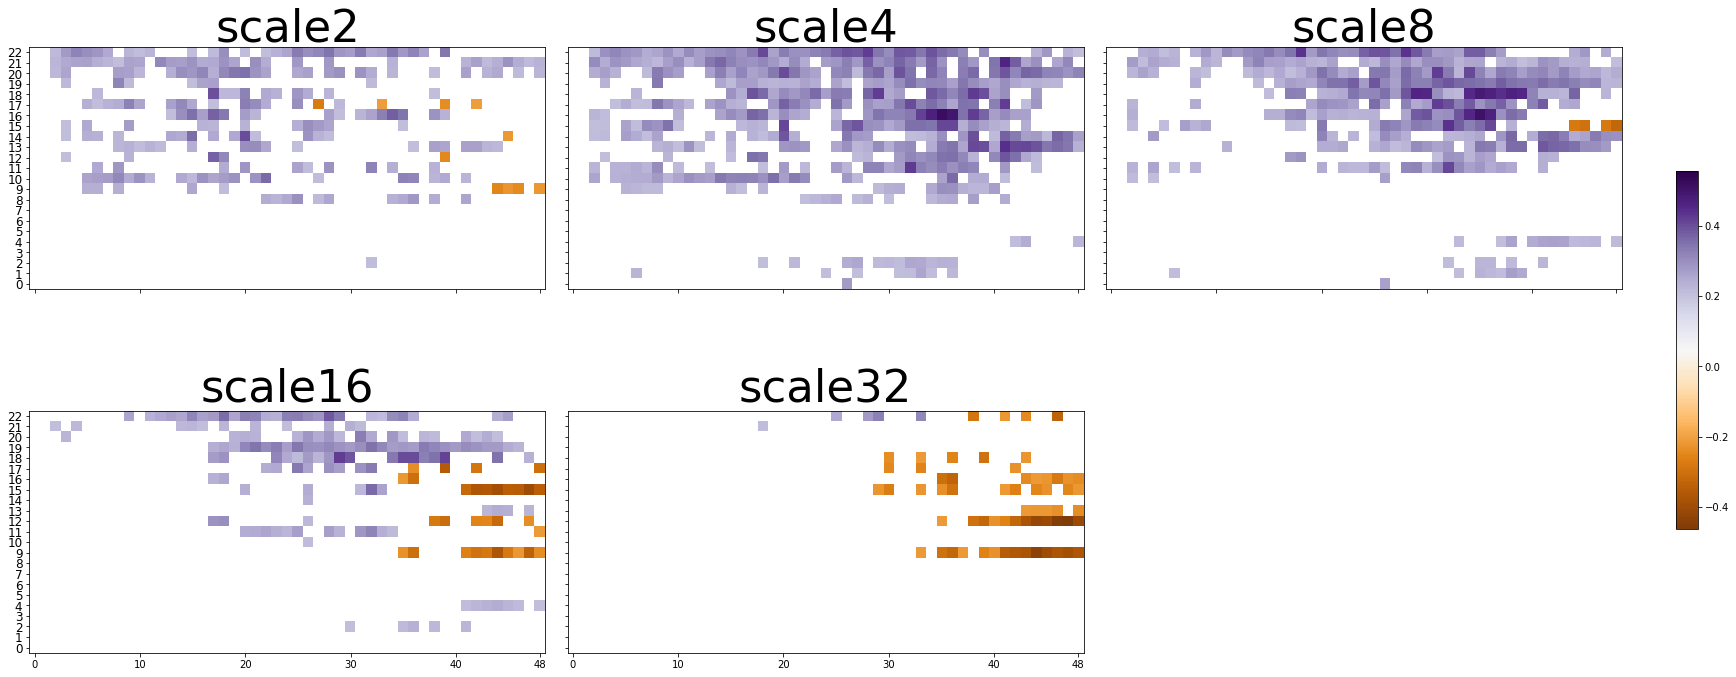

In [21]:
# scale x study grid of all-net heatmaps
fig, axes = plt.subplots(
    2, 3, figsize=(24, 10), sharex=True, sharey=True, constrained_layout=True
)
x_ticks = np.concatenate(
    [np.arange(0, df_ibc.columns[-1], 10), np.array([df_ibc.columns[-1]])]
)
title_fontsize = 45
axislabel_fontsize = 12


for axidx, scale in enumerate(SCALE_NAMES):
    ax = axes[axidx // 3, axidx % 3]

    c = df_ibc_s.loc[(slice(None), _study, scale),].iloc[order[::-1], :]
    im = ax.imshow(c, vmin=df_ibc_s.min().min(), vmax=df_ibc_s.max().max(), cmap="PuOr")

    # p = df3.loc[(slice(None), study, scale), :].droplevel(["scale", "study"])
    # ax.contour(p, levels=[0.05], colors='orange', linewidths=5, corner_mask = False)

    ax.set_xticks(x_ticks)
    ax.set_yticks(modelnum_mapping)
    ax.set_yticklabels(modelnum_mapping[::-1], fontsize=axislabel_fontsize)
    ax.set_title(scale, fontsize=title_fontsize)

axes[-1,-1].set_visible(False)
fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.2, pad=0.03, shrink=0.5)
# plt.subplots_adjust(hspace=0.2, wspace=.005)
#plt.tight_layout()

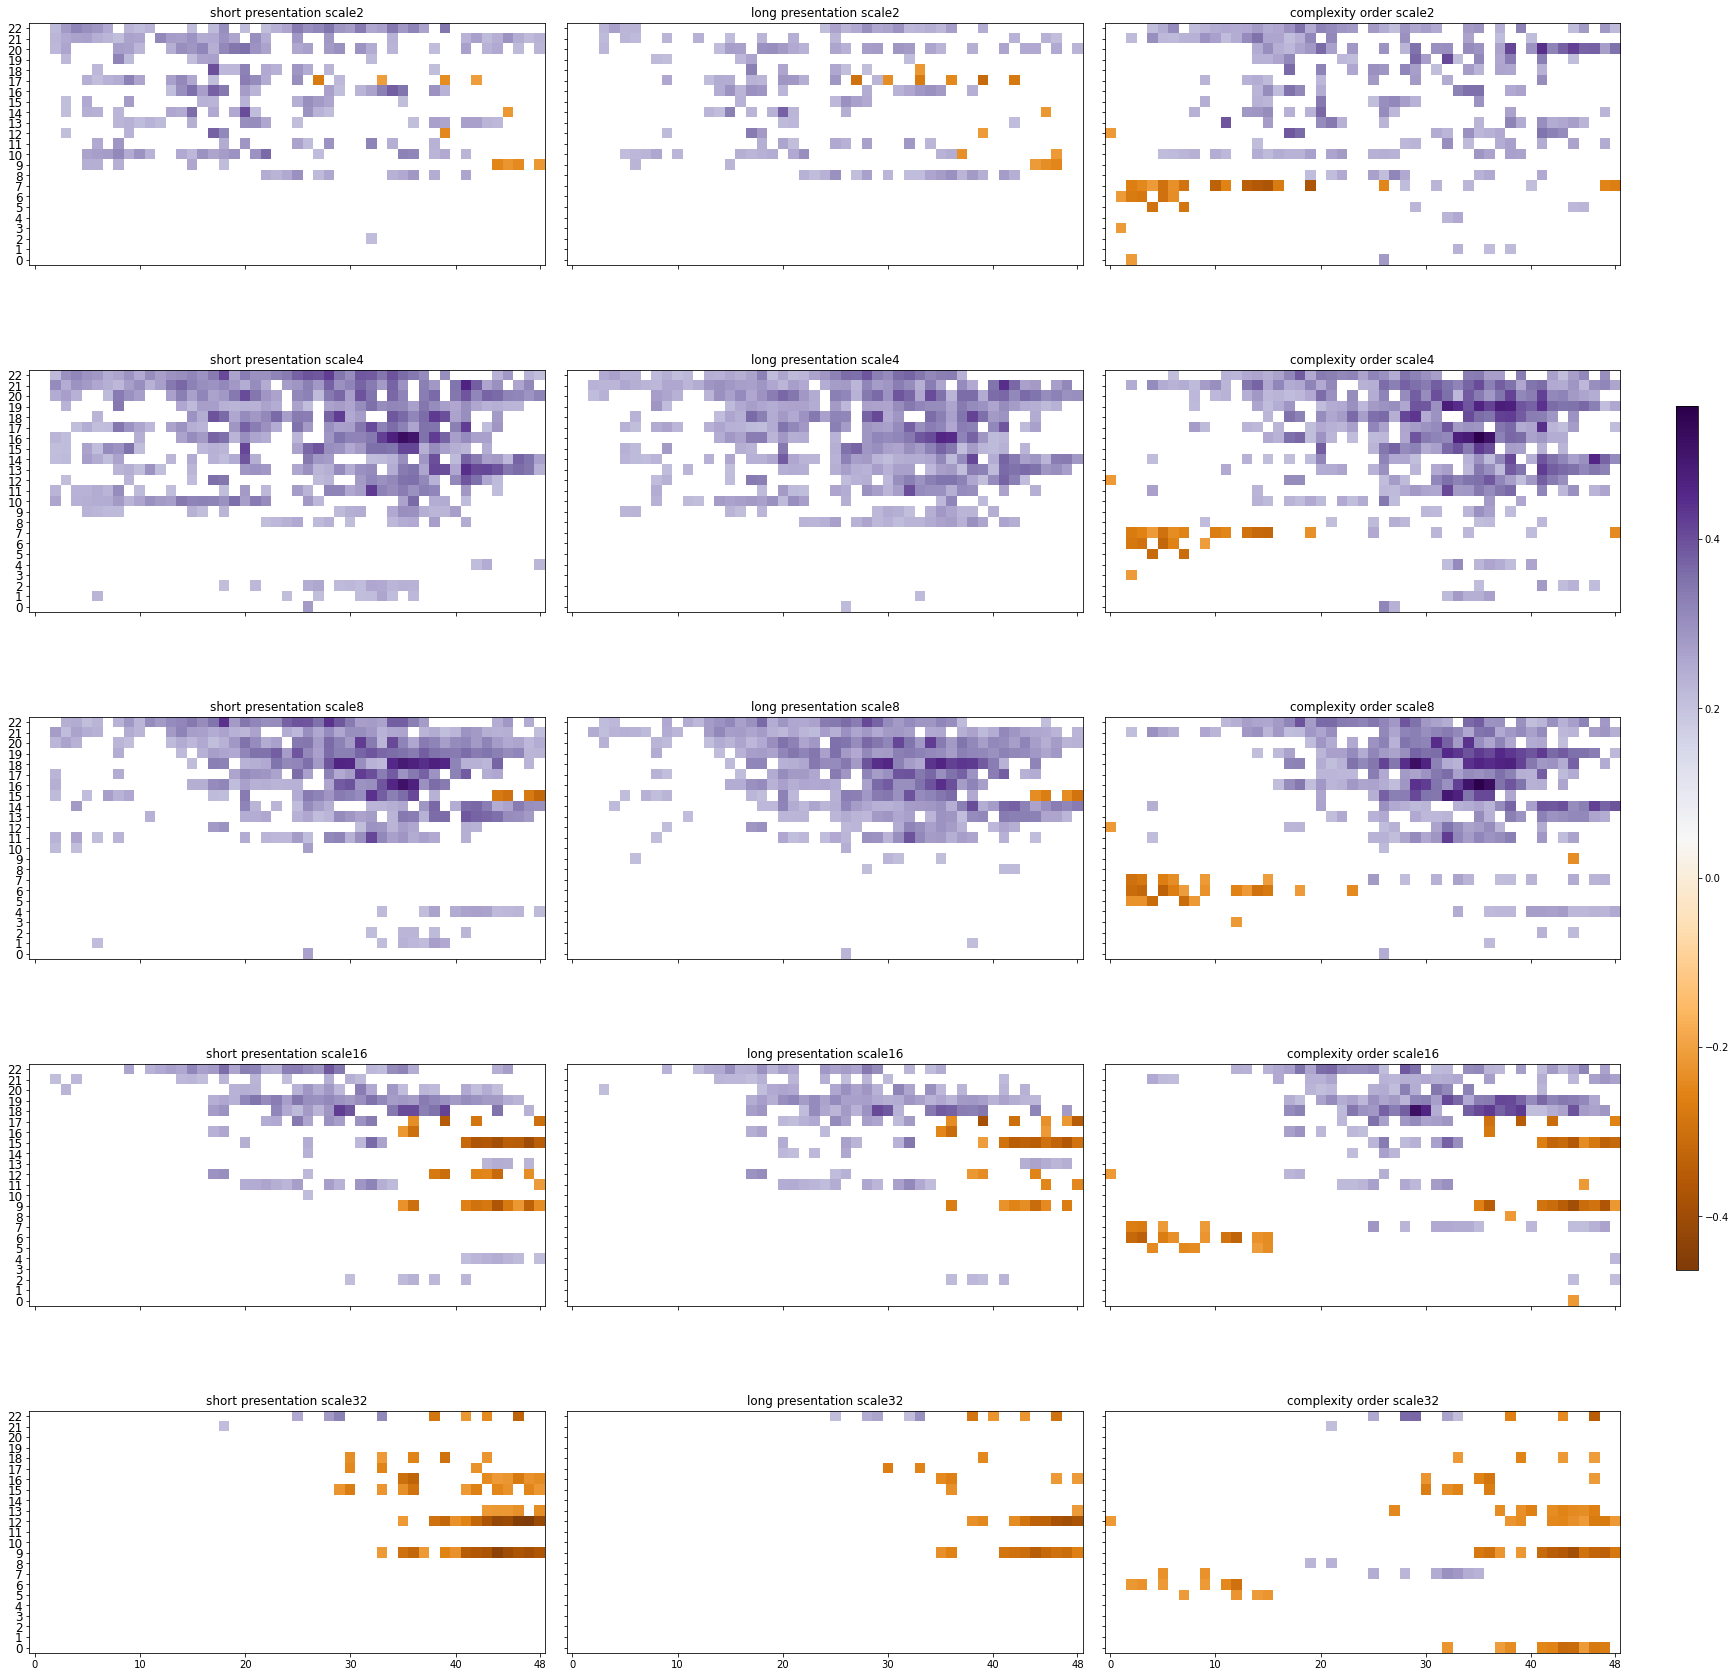

In [23]:
# scale x study grid of all-net heatmaps
fig, axes = plt.subplots(
    5, 3, figsize=(24, 24), sharex=True, sharey=True, constrained_layout=True
)
x_ticks = np.concatenate(
    [np.arange(0, df_ibc.columns[-1], 10), np.array([df_ibc.columns[-1]])]
)
title_fontsize = 30
axislabel_fontsize = 12


from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("blue_magenta", ["blue", "magenta"])

for idsc, scale in enumerate(SCALE_NAMES):
    for idst, study in enumerate(STUDY_NAMES[:-1]):
        ax = axes[idsc, idst]

        c = df_ibc_s.loc[(slice(None), study, scale),].iloc[order[::-1], :]
        im = ax.imshow(
            c, vmin=df_ibc_s.min().min(), vmax=df_ibc_s.max().max(), cmap="PuOr"
        )

        # p = df3.loc[(slice(None), study, scale), :].droplevel(["scale", "study"])
        # ax.contour(p, levels=[0.05], colors='orange', linewidths=5, corner_mask = False)

        ax.set_xticks(x_ticks)
        ax.set_yticks(modelnum_mapping)
        ax.set_yticklabels(modelnum_mapping[::-1], fontsize=axislabel_fontsize)
        ax.set_title(study + " " + scale)

fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.2, pad=0.03, shrink=0.5)
# plt.subplots_adjust(hspace=0.2, wspace=.005)
# plt.tight_layout()

[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '18'),
 Text(0, 0, '19'),
 Text(0, 0, '20'),
 Text(0, 0, '21'),
 Text(0, 0, '22')]

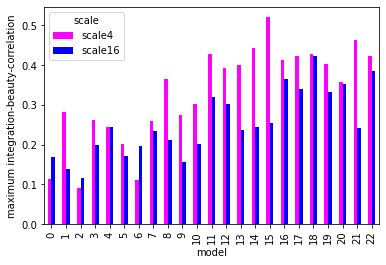

In [89]:
# correlation of best predicting layer in each network, scale4 vs scale16
title_fontsize = 30
axislabel_fontsize = 20

ax = (
    df_ibc.loc[(slice(None), _study, ["scale4", "scale16"])]
    .droplevel("study")
    .max(axis=1)
    .unstack("scale")
    .iloc[order, :]
    .plot.bar(stacked=False, color={"scale4": "magenta", "scale16": "blue"})
)
ax.set_ylabel("maximum integration-beauty-correlation")
ax.set_xticklabels(modelnum_mapping)

# blocking (average vs maxpool)
for  scale4 (!)

## plot1: show oscillations
explain why blocking

In [ ]:
df1 = dfi.loc[(slice(None), "places1", "scale16"), :].droplevel(["scale", "dataset"])
df2 = df_ibcorr.loc[(slice(None), "short presentation", "scale16"), :].droplevel(
    ["scale", "study"]
)

In [ ]:
# sort by std of specific layers
df_maxidx = (
    df1.iloc[:, slice(27, 43 + 1)]
    .std(axis=1)
    .groupby("model")
    .idxmax()
    .apply(lambda tup: tup[1])
)

In [ ]:
# sort by std in all layers
df_maxidx = df1.std(axis=1).groupby("model").idxmax().apply(lambda tup: tup[1])

In [ ]:
# integration
fig, axes = plt.subplots(1, 3, figsize=(33, 23), sharey=True)
layers = slice(0, 49)  # first to last layers to plot
yscaling = 3
axtitle_fontsize = 38
axeslabel_fontsize = 30
x_ticks = np.concatenate([np.arange(0, data.index[-1], 10), np.array([data.index[-1]])])

# individual images
ax = axes[0]
for y, model in enumerate(MODEL_NAMES):
    maxidx = df_maxidx.loc[model]
    data = df1.loc[(model, maxidx), :].iloc[layers]
    ax.plot(yscaling * data + 2 * y + 3)
    ax.axhline(
        y=2 * y + 1, color="grey", linestyle="--", linewidth=0.5, xmin=0.05, xmax=0.95
    )
for layer in range(27, 45, 3):
    ax.axvline(layer, color="thistle", ymin=0.01, ymax=0.99)
ax.set_title("single image integration highest std.", fontsize=axtitle_fontsize)
ax.set_xlabel("network layer", fontsize=axeslabel_fontsize)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, fontsize=axeslabel_fontsize)
# shared y-axis
ax.set_ylim(0, 23 * 2 + 3)
ax.set_yticks(range(1, 23 * 2, 2))
ax.set_yticklabels(range(1, 23 + 1), fontsize=axeslabel_fontsize)
ax.set_ylabel("taskonomy network (see dict below)", fontsize=axeslabel_fontsize)


# network median
ax = axes[1]
tmp = df1.groupby("model").median()
for y, model in enumerate(MODEL_NAMES):
    ax.plot(yscaling * tmp.iloc[y, layers] + 2 * y + 3)
    ax.axhline(
        y=2 * y + 1, color="grey", linestyle="--", linewidth=0.5, xmin=0.05, xmax=0.95
    )
for layer in range(27, 45, 3):
    ax.axvline(layer, color="thistle", ymin=0.01, ymax=0.99)
ax.set_title("mean spatial integration", fontsize=axtitle_fontsize)
ax.set_xlabel("network layer", fontsize=axeslabel_fontsize)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, fontsize=axeslabel_fontsize)


# ibcorr
ax = axes[2]
for y, model in enumerate(MODEL_NAMES):
    ax.plot(2 * yscaling * df2.loc[model] + 2 * y)
    ax.axhline(
        y=2 * y + 1, color="grey", linestyle="--", linewidth=0.5, xmin=0.05, xmax=0.95
    )
for layer in range(26, 45, 3):
    ax.axvline(layer, color="thistle", ymin=0.01, ymax=0.99)
ax.set_title("integration-beauty correlation", fontsize=axtitle_fontsize)
ax.set_xlabel("network layer", fontsize=axeslabel_fontsize)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, fontsize=axeslabel_fontsize)

In [ ]:
# ibcorr
# unblocked view of scale16

tmp = df2.loc[(slice(None), study, "scale16"), :]

fig, ax = plt.subplots(figsize=(5, 23))


# for idst, study in enumerate(STUDY_NAMES):
#     corr= df_ib.loc[(slice(None),study, 'scale16'),:].droplevel(['scale','study'])
#     p   = df_p.loc[(slice(None), study,scale),:].droplevel(['scale','study'])
#     ax = axes[idst]

#     ax.set_yticks(range(len(corr.index)))
#     #ax.set_yticklabels(corr.index)
#     ax.set_title(study + ' ' + scale)

for y, model in enumerate(MODEL_NAMES):
    ax.plot(10 * tmp.iloc[y, slice(None)] + 2 * y + 1)
    ax.axhline(y=2 * y + 1, color="grey", linestyle="--", linewidth=0.5)

ax.set_ylim(-3, 23 * 2 + 3)
ax.set_yticks(range(1, 23 * 2, 2))
ax.set_yticklabels(range(1, 23 + 1))

# Plot each line with its offset
# ax.plot(x, y1, label='sin(x)')
# ax.plot(x, y2_offset, label=f'cos(x) + {offset}')
# ax.plot(x, y3_offset, label=f'exp(x/10) + {2 * offset}')

# # Optionally, add horizontal lines to indicate the offset
# ax.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
# ax.axhline(y=offset, color='grey', linestyle='--', linewidth=0.5)
# ax.axhline(y=2 * offset, color='grey', linestyle='--', linewidth=0.5)

# # Add legends, labels, and title
# ax.legend()
# ax.set_xlabel('X-axis')
# ax.set_ylabel('Y-axis')
# ax.set_title('Multiple Lines with Y-Offset')

# # Show the plot
# plt.show()

## plot2.1: inside block layer structure of oscillations
resnet50 architecture explained before

## plot2.2: ibcorr difference from blocking

In [ ]:
# unblocked ibcorr
df1 = df_ibc.loc[(slice(None), "short presentation", _scale)].fillna(0)


# unblocked integration
df3 = dfi.loc[(slice(None), "places1", _scale)].fillna(0)


# maxpool ibcorr
df5 = df1.T.groupby(BLOCKING_GROUPS).max().T

# maxpool integration
# per block layer with best beauty prediction
bl = df1.T.groupby(BLOCKING_GROUPS).idxmax().T
bl_stacked = (
    bl.stack()
    .droplevel(None)
    .to_frame()
    .rename({0: "layer"}, axis=1)
    .reset_index()
    .values
)

# format d3 for indexing
df3.columns.name = "layer"
df3_stacked = df3.stack("layer").reorder_levels(["model", "layer", "img"]).to_frame()

# indices for indexing
num_blocks = np.unique(BLOCKING_GROUPS).size
num_images = df3.index.get_level_values("img").unique().size
num_models = df3.index.get_level_values("model").unique().size
blocked_layer_idx = np.tile(
    np.repeat(
        np.arange(num_blocks),
        num_images,
    ),
    num_models,
)

# index best layer per block
df6 = (
    df3_stacked.reset_index(level="img")
    .loc[bl_stacked.tolist(), :]
    .droplevel("layer")
    .assign(layer=blocked_layer_idx)
    .reset_index()
    .set_index(["model", "img", "layer"])
    .unstack("layer")
    .droplevel(None, axis=1)
)

In [ ]:
# save maxpooled
# for now, this is only for data subset

# integration
for mo, da, sc in product(MODEL_NAMES, [_dataset], [_scale]):
    df6.loc[(mo, slice(None))].to_csv(
        os.path.join(PATH_INTEGRATION_MAXPOOL, mo, da, sc, "correlations.csv"),
        header=None,
        index=False,
    )


# ibcorr
for mo, st, sc in product(MODEL_NAMES, [_study], [_scale]):
    df5.loc[mo].to_csv(
        os.path.join(PATH_IBCORR_MAXPOOL, mo, st, sc, "ib_correlations.csv"),
        header=None,
        index=False,
    )

In [ ]:
# what's better: significant difference between average and max
df_s = pd.DataFrame(index=MODEL_NAMES, columns=df3.columns)
for mo in MODEL_NAMES:
    for layer in df2.columns:
        df_s.loc[mo, layer] = compare_corr(
            r_yx1=df2.loc[mo, layer],  # avg_ibc
            r_yx2=df5.loc[mo, layer],  # max_ibc
            X1=df4.loc[(mo, slice(None)), layer],  # avg_i
            X2=df6.loc[(mo, slice(None)), layer],  # max_i
        )

from scipy.stats import norm

alpha_mcc = (0.05 / 17) * 2

upper = (df_s > norm.ppf(1 - alpha_mcc / 2)).sum().sum()
lower = (df_s < norm.ppf(alpha_mcc / 2)).sum().sum()

print(f"There are {upper+lower} layers in all networks with a significant difference")

In [ ]:
xp, yp = 4, 6
fig, axes = plt.subplots(yp, xp, figsize=(40, 60), sharex=True, sharey=True)
axtitle_fontsize = 50
axeslabel_fontsize = 40
linewidth = 4.5
x_ticks = np.concatenate(
    [np.arange(0, df1.columns[-1], 10), np.array([df1.columns[-1]])]
)

# plot the blocked value in the middle index of the unblocked values, eg 2, 2, 3, ->3<-, 3, 4, 4, ...
block_plot_indices = [0] + list(range(2, 49, 3))
block_plot_indices

for ax, mo, idx in zip(axes.flat, MODEL_NAMES, range(len(MODEL_NAMES))):
    ax.axhline(0, color="grey", linestyle="--", linewidth=0.5, xmin=0.05, xmax=0.95)
    ax.plot(
        df1.loc[mo], alpha=0.85, c="lightblue", linewidth=linewidth
    )  # unblocked ibcorr
    ax.plot(
        block_plot_indices,
        df5.loc[mo],
        label="maximum corr.",
        c="magenta",
        linewidth=linewidth,
    )  # max ibcorr
    ax.plot(
        block_plot_indices,
        df2.loc[mo],
        label="corr. from avg int.",
        c="blue",
        linewidth=linewidth,
    )  # avg ibcorr

    ax.set_title(mo, fontsize=axtitle_fontsize)

    if idx % xp == 0:
        ax.set_ylabel("correlation", fontsize=axeslabel_fontsize)
        ax.tick_params(axis="y", labelsize=axeslabel_fontsize)

    if idx > 19:
        ax.set_xlabel("network layer", fontsize=axeslabel_fontsize)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks, fontsize=axeslabel_fontsize)

    # plot significant difference between avg and max and indicate which's better
    # ax.

    # ax.legend(title="correlation with ... integration", loc="lower center")

handles, labels = ax.get_legend_handles_labels()
ax = axes.flat[-1]
ax.legend(
    handles, labels, fontsize=45, loc="center", title="blockwise", title_fontsize=60
)
ax.set_xticks([])
ax.set_xticklabels([])

for s in ax.spines.values():
    s.set_visible(False)
# for ax in axes.flat[len(MODEL_NAMES) :]:
#    ax.set_visible(False)

# predictive layers only

In [90]:
# unblocked ibcorr
df1 = df_ibc.loc[(slice(None), "short presentation", _scale)].fillna(0)

# unblocked integration
df2 = dfi.loc[(slice(None), "places1", _scale)].fillna(0)
# format d2 for indexing
df2.columns.name = "layer"
df2_stacked = df2.stack("layer").reorder_levels(["model", "layer", "img"]).to_frame()

# maxpooled ibcorr
df3 = df1.T.groupby(BLOCKING_GROUPS).max().T

# per block layer with best beauty prediction
bl = df1.T.groupby(BLOCKING_GROUPS).idxmax().T
bl_stacked = (
    bl.stack()
    .droplevel(None)
    .to_frame()
    .rename({0: "layer"}, axis=1)
    .reset_index()
    .values
)
# indices for indexing
num_blocks = np.unique(BLOCKING_GROUPS).size
num_images = df2.index.get_level_values("img").unique().size
num_models = df2.index.get_level_values("model").unique().size
blocked_layer_idx = np.tile(
    np.repeat(
        np.arange(num_blocks),
        num_images,
    ),
    num_models,
)

# maxpool integration  (index best layer per block)
df4 = (
    df2_stacked.reset_index(level="img")
    .loc[bl_stacked.tolist(), :]
    .droplevel("layer")
    .assign(layer=blocked_layer_idx)
    .reset_index()
    .set_index(["model", "img", "layer"])
    .unstack("layer")
    .droplevel(None, axis=1)
)

# unblocked pvalues
df5 = dfp.loc[(slice(None), "short presentation", _scale)].fillna(0)


blocked_layer_idx = np.tile(
    np.arange(num_blocks),
    num_models,
)
# maxpooled pvalues
df6 = (
    df5.stack("layer")
    .loc[bl_stacked.tolist(), :]
    .droplevel("layer")
    .assign(layer=blocked_layer_idx)
    .reset_index()
    .set_index(["model", "layer"])
    .unstack("layer")
    .droplevel(None, axis=1)
)

ValueError: The name layer occurs multiple times, use a level number

In [ ]:
# plot only significant pixels, bonferroni MCC
adjusted_pvalue = 0.05 / 17
mask = (df6 > adjusted_pvalue).values
df3.iloc[mask] = np.nan

In [ ]:
# better visualizaiton, sort models by integration
# order = dfi.abs().groupby("model").sum().sum(axis=1).argsort()
order = df_ibc.abs().groupby("model").sum().sum(axis=1).argsort()

# model names to numbers mapping
modelnum_mapping = order.sort_values()

In [ ]:
# scale x study grid of all-net heatmaps
fig, ax = plt.subplots(
    1,
    1,
    figsize=(13, 8),  # constrained_layout=False
)
x_ticks = np.concatenate(
    [np.arange(0, df3.columns[-1], 6), np.array([df3.columns[-1]])]
)
title_fontsize = 40
axislabel_fontsize = 20


c = df3.iloc[order[::-1], :]
im = ax.imshow(c, vmin=c.min().min(), vmax=c.max().max(), cmap="BuPu", aspect="auto")

# annotations
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, fontsize=axislabel_fontsize)
ax.set_xlabel("layer", fontsize=axislabel_fontsize)
ax.set_yticks(modelnum_mapping)
ax.set_yticklabels(modelnum_mapping[::-1], fontsize=axislabel_fontsize)
ax.set_ylabel("model", fontsize=axislabel_fontsize)
ax.set_title(_scale, fontsize=title_fontsize)
ax.grid(which="major")
fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.2, pad=0.03, shrink=0.8)

In [ ]:
models_to_remove = set(["edge_occlusion", "inpainting", "keypoints","normal","jigsaw"])
_models = set(MODEL_NAMES).difference(models_to_remove)

In [ ]:
df3.mean().plot()

### further plots

In [ ]:
# compare this to selected networks, scale, dataset, layers
df_ibcorr.loc[(slice(None), "short presentation", slice(None)), :].mean().plot()

In [ ]:
# Calculate column means and standard deviations
means = df3.mean()
stds = df3.std()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(means.index, means, label="Mean", color="blue")

# Add shaded area (std) around the mean
plt.fill_between(
    means.index,
    means - stds,
    means + stds,
    color="blue",
    alpha=0.15,
    label="±1 Std Dev",
)

## Add hatching to the shaded area
# plt.fill_between(means.index, means - stds, means + stds, color='none', hatch='/', edgecolor='blue', alpha=0.3)

# Customize plot
plt.title("Column Means with Shaded Standard Deviation")
plt.xlabel("Columns")
plt.ylabel("Values")
plt.legend()
plt.grid(True)

plt.show()

# test: heatmap significance

In [ ]:
data = np.pad(np.random.random((10, 10)), 1)
data.shape

In [ ]:
data = np.random.random((10, 10))

In [ ]:
# data = np.pad(np.random.random((10, 10)), 1)
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

# Example significance mask (True for significant, False for not)
# Let's assume that any value greater than 0.8 is significant
significance_mask = data > 0.8

# Plotting the heatmap
ax[0, 0].imshow(data, cmap="viridis")

# Overlay the contours for significance
ax[0, 0].contour(data, levels=[0.5], colors="orange", linewidths=5, corner_mask=False)

# Add colorbar
# plt.colorbar()

# Show the plot
plt.show()